## Word Embedding

I tried create feature from word embeddding approaches. However, the result didn't turn out well. So we discarded this feature

In [114]:
# ! pip install gensim
# ! pip install regex
# !pip install google-compute-engine
# ! pip install --upgrade gensim 


In [115]:
import re
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath
import numpy as np

In [116]:
# download word2vec file from this link https://nlp.stanford.edu/projects/glove/

glove = KeyedVectors.load_word2vec_format("./glove.twitter.27B.100d.50K.txt.w2v.txt", binary=False)

In [117]:
glove.most_similar("tesla", topn=10)

[('nissan', 0.656598687171936),
 ('toyota', 0.6447548270225525),
 ('edison', 0.6437983512878418),
 ('motors', 0.6417877078056335),
 ('ibm', 0.614520251750946),
 ('boeing', 0.6127479672431946),
 ('jaguar', 0.6016720533370972),
 ('mazda', 0.5945785641670227),
 ('rover', 0.5930163860321045),
 ('ford', 0.5923380851745605)]

In [118]:
import pandas as pd
dtype={0:'object',1:'object',2:'int64',3:'int64',4:'object',5:'object',6:'object',7:'object',8:'object',9:'object',
      10:'object',11:'object',12:'object',13:'object'}
Elon = pd.read_csv('../../data/Elon.csv', sep=';', error_bad_lines=False,dtype=dtype)
Elon = Elon.fillna('')

In [119]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    from nltk.corpus import stopwords
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model
    if len(words) > 0:
        for word in words:
            if word in index2word_set: 
                nwords = nwords + 1.
                feature_vec = np.add(feature_vec,model[word])
    
        feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
#         print(review)
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

In [124]:
# find the average value of word embedding vectors.

clean_train_reviews = []
for review in Elon.text.fillna(''):
    clean_train_reviews.append(review_to_wordlist(str(review), remove_stopwords=True))
clean_train_reviews

[['starship', 'land', 'ring', 'fire'],
 [],
 ['yes'],
 ['winter', 'coming'],
 ['thinking',
  'adding',
  'giant',
  'stainless',
  'steel',
  'dragon',
  'wings',
  'starship'],
 ['tweet',
  'take',
  'immense',
  'effort',
  'fair',
  'point',
  'tho',
  'powerwall',
  'production',
  'ramping',
  'fast',
  'tesla',
  'cell',
  'starved',
  'last',
  'year',
  'switch',
  'lines',
  'make',
  'packs',
  'cars',
  'meant',
  'powerwall',
  'production',
  'living',
  'scraps'],
 ['deal'],
 ['please', 'support', 'campaign', 'rebrand', 'wsj', 'emoji'],
 [],
 ['point', 'theonion', 'get', 'room'],
 ['use',
  'handy',
  'guidehttps',
  'www',
  'theonion',
  'com',
  'onion',
  'guide',
  'blockchain',
  'technology'],
 ['yes'],
 ['good', 'interview', 'lexfridman'],
 ['truth'],
 ['exactly'],
 ['embarrassing', 'change'],
 ['read', 'right'],
 ['haha', 'true'],
 ['always',
  'thought',
  'fundamental',
  'good',
  'tesla',
  'measured',
  'number',
  'years',
  'accelerates',
  'transition',
 

In [125]:
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, glove, 100)
trainDataVecs

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


array([[-0.01109233,  0.56364995, -0.41942   , ..., -0.18287432,
        -0.08897334, -0.15578   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54303   ,  0.19819   ,  0.078711  , ...,  0.46258   ,
         0.43341   , -0.5481    ],
       ...,
       [ 0.01395586, -0.02692223,  0.10085778, ...,  0.14798911,
         0.01513933, -0.18029468],
       [ 0.1085761 ,  0.04534331,  0.12996031, ..., -0.2019325 ,
        -0.24917929,  0.01265   ],
       [ 0.2200507 ,  0.42776972,  0.15733984, ..., -0.21444428,
         0.09951414,  0.13546571]], dtype=float32)

In [122]:
import pickle
with open('./word2vec.pickle', 'wb') as handle:
        pickle.dump(trainDataVecs, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [108]:
glove.most_similar(positive=[trainDataVecs[2000]], topn=1)

[('should', 0.8573559522628784)]

In [179]:
# tried cluster the average of word embeding vector together

from sklearn.cluster import AgglomerativeClustering
i = 6
clustering = AgglomerativeClustering(n_clusters=i,affinity='euclidean', linkage='ward').fit(np.nan_to_num(trainDataVecs))
# https://www.dummies.com/programming/big-data/data-science/data-science-performing-hierarchical-clustering-with-python/
# cosine is good when ther are many vars

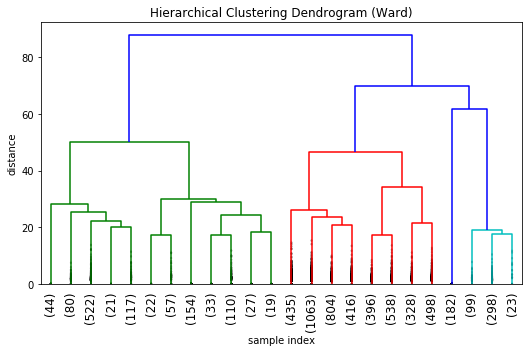

In [149]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linkage_matrix = linkage(np.nan_to_num(trainDataVecs), 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [181]:
center = pd.DataFrame(np.column_stack((np.nan_to_num(trainDataVecs),clustering.labels_ ))).groupby(100).mean()

In [182]:
# see the most similar words of the centers of each cluster

for i, x in center.iterrows():
    print(i)
    print(glove.most_similar(positive=[np.array(x)], topn=5))

0.0
[('the', 0.8891524076461792), ('it', 0.8807798027992249), ('that', 0.8793078660964966), ('this', 0.8786090612411499), ('there', 0.8783589005470276)]
1.0
[('there', 0.9507919549942017), ('think', 0.9450831413269043), ('but', 0.9447606205940247), ('that', 0.9370989203453064), ('know', 0.9353368282318115)]
2.0
[('yes', 0.9727528691291809), ('yeah', 0.9409561157226562), ('well', 0.9136782884597778), ('sure', 0.887441098690033), ('maybe', 0.8773466944694519)]
3.0
[('خسارة', 0.0), ('اختر', 0.0), ('crlh', 0.0), ('charme', 0.0), ('صاحي', 0.0)]
4.0
[('twitter', 0.8182536363601685), ('to', 0.7806164622306824), ('as', 0.7767356634140015), ('do', 0.7734358310699463), ('post', 0.7715197205543518)]
5.0
[('there', 0.9369471073150635), ('that', 0.9228792190551758), ('it', 0.9178262948989868), ('but', 0.9175832271575928), ('way', 0.9131141901016235)]


In [166]:
len(clustering.labels_)

6286